# 20장. 군집화 (Clustering)

In [1]:
!pip install seaborn

## 1. 데이터셋 (IRIS)
https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data

In [2]:
import requests
import os

data = requests.get("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data")
path = os.path.join('data', 'iris.data')
with open(path, "w") as f:
  f.write(data.text)

### 1.1 데이터셋 읽기

In [3]:
import pandas as pd
column_names = ['sepal length', 'sepal width', 'petal length', 'petal width', 'species']
dataset = pd.read_csv(path, names=column_names)
dataset.head()

,sepal length,sepal width,petal length,petal width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal length  150 non-null    float64
 1   sepal width   150 non-null    float64
 2   petal length  150 non-null    float64
 3   petal width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


## 2. 데이터 탐색

### 2.1 요약 통계량

In [5]:
dataset.describe()

,sepal length,sepal width,petal length,petal width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


### 2.2 단일 변수 분석

#### 2.2.1 히스토그램

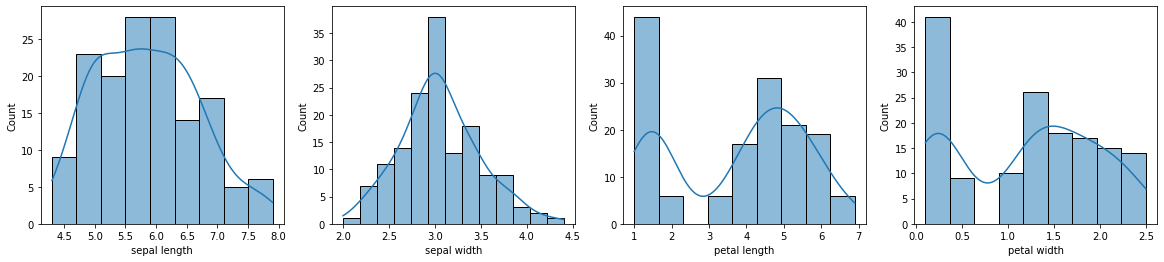

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=[20,4])
for i, column in enumerate(dataset.describe().columns):
    plt.subplot(1,4,i+1)
    sns.histplot(data=dataset, x=column, kde=True)
plt.show()

#### 2.2.2 박스 플롯

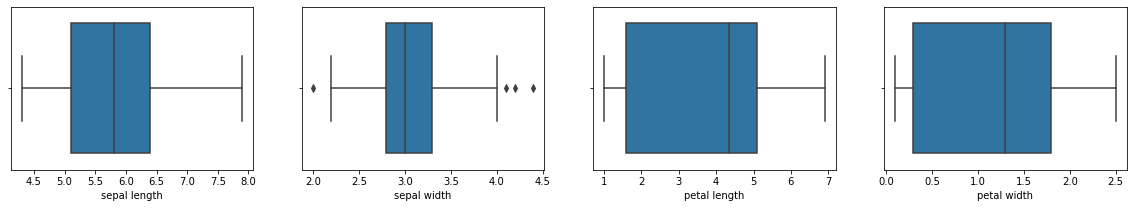

In [7]:
plt.figure(figsize=[20,3])
for i in enumerate(dataset.describe().columns[:4]):
    plt.subplot(1,4,i[0]+1)
    sns.boxplot(x=dataset[i[1]])

plt.show()

### 2.3 두 변수 관계 분석
#### 2.3.1 산포도 행렬

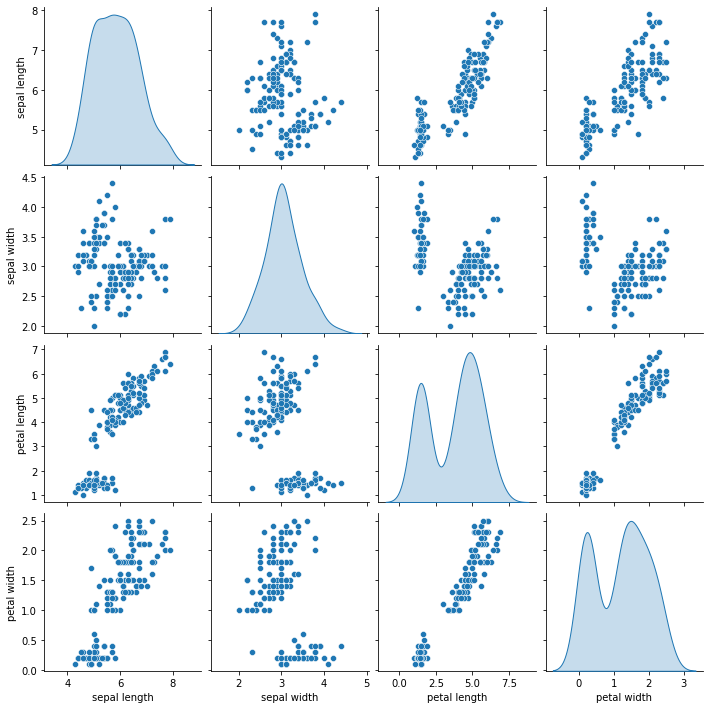

In [8]:
sns.pairplot(dataset, diag_kind="kde")
plt.show()

#### 2.3.2 히트맵

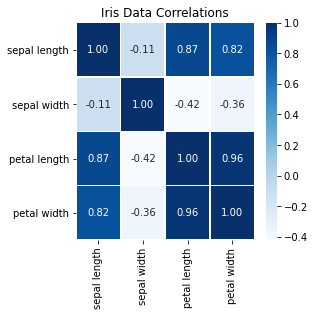

In [9]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(dataset.corr(), linewidths=.5, annot=True, fmt=".2f", cmap='Blues')
plt.title('Iris Data Correlations')
plt.show()

## 3. 데이터 전처리

### 3.1 데이터 추출

In [10]:
clusterdata = dataset.iloc[:,:-1]
inputs = clusterdata.iloc[:,:].values.tolist()
columns = clusterdata.keys().tolist()
column2index ={ column : i for i, column in enumerate(columns)}
print('columns = ', columns)
print('column2index = ', column2index)

columns =  ['sepal length', 'sepal width', 'petal length', 'petal width']
column2index =  {'sepal length': 0, 'sepal width': 1, 'petal length': 2, 'petal width': 3}


### 3.2 데이터 표준화

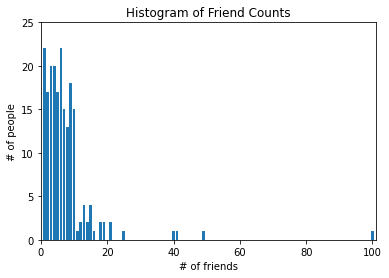

In [11]:
from scratch.working_with_data import scale, rescale, Vector
from typing import List

inputs_normed = rescale(inputs)

## 4. K-평균 군집화

### Q1. 손실 곡선을 보고 K 선택하기
손실을 최소화 하는 클러스터 수 𝐾를 찾아보시오.
단, 𝐾는 20까지 확인해 보라.

0it [00:00, ?it/s]
changed: 1 / 150: : 2it [00:00, 222.17it/s]
changed: 2 / 150: : 7it [00:00, 199.98it/s]
changed: 2 / 150: : 7it [00:00, 152.19it/s]
changed: 1 / 150: : 7it [00:00, 189.24it/s]
changed: 1 / 150: : 8it [00:00, 135.59it/s]
changed: 2 / 150: : 7it [00:00, 118.65it/s]
changed: 2 / 150: : 14it [00:00, 137.26it/s]
changed: 1 / 150: : 10it [00:00, 153.85it/s]
changed: 1 / 150: : 11it [00:00, 142.85it/s]
changed: 1 / 150: : 17it [00:00, 153.15it/s]
changed: 1 / 150: : 8it [00:00, 100.00it/s]
changed: 1 / 150: : 13it [00:00, 108.34it/s]
changed: 1 / 150: : 13it [00:00, 97.03it/s] 
changed: 2 / 150: : 11it [00:00, 113.42it/s]
changed: 1 / 150: : 8it [00:00, 48.19it/s]
changed: 3 / 150: : 6it [00:00, 49.59it/s]
changed: 1 / 150: : 7it [00:00, 57.85it/s]
changed: 1 / 150: : 14it [00:00, 93.96it/s] 
changed: 3 / 150: : 6it [00:00, 72.89it/s]


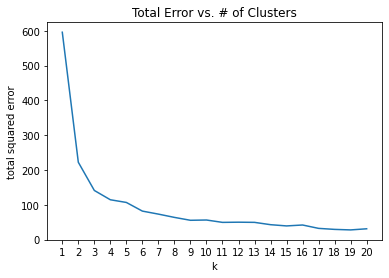

In [12]:
from typing import List
from scratch.linear_algebra import vector_mean, Vector, squared_distance
import itertools
import random
import tqdm

#해밍거리
def num_differences(v1: Vector, v2: Vector) -> int:
    return len([x1 for x1, x2 in zip(v1, v2) if x1 != x2])

#군집의 평균 계산
def cluster_means(k: int,
                  inputs: List[Vector],
                  assignments: List[int]) -> List[Vector]:
    # clusters[i] contains the inputs whose assignment is i
    clusters = [[] for i in range(k)]
    for input, assignment in zip(inputs, assignments):
        clusters[assignment].append(input)

    # if a cluster is empty, just use a random point
    return [vector_mean(cluster) if cluster else random.choice(inputs)
            for cluster in clusters]

#Kmeans 클래스
class KMeans:
    def __init__(self, k: int) -> None:
        self.k = k                      # number of clusters
        self.means = None
        self.assignments = None

    def classify(self, input: Vector) -> int:
        """return the index of the cluster closest to the input"""
        return min(range(self.k),
                   key=lambda i: squared_distance(input, self.means[i]))

    def train(self, inputs: List[Vector]) -> None:
        # Start with random assignments
        self.assignments = [random.randrange(self.k) for _ in inputs]
        
        with tqdm.tqdm(itertools.count()) as t:
            for _ in t:
                # Compute means and find new assignments
                self.means = cluster_means(self.k, inputs, self.assignments)
                new_assignments = [self.classify(input) for input in inputs]

                # Check how many assignments changed and if we're done
                num_changed = num_differences(self.assignments, new_assignments)
                if num_changed == 0:
                    return

                # Otherwise keep the new assignments, and compute new means
                self.assignments = new_assignments
                t.set_description(f"changed: {num_changed} / {len(inputs)}")

#손실 계산
def squared_clustering_errors(inputs: List[Vector], k: int) -> float:
    """finds the total squared error from k-means clustering the inputs"""
    clusterer = KMeans(k)
    clusterer.train(inputs)
    means = clusterer.means
    assignments = [clusterer.classify(input) for input in inputs]

    return sum(squared_distance(input, means[cluster])
               for input, cluster in zip(inputs, assignments))

ks = range(1, 21)
errors = [squared_clustering_errors(inputs_normed, k) for k in ks]

plt.plot(ks, errors)
plt.xticks(ks)
plt.xlabel("k")
plt.ylabel("total squared error")
plt.title("Total Error vs. # of Clusters")
plt.show()

### Q2. 군집화 및 결과 확인 (Q)
𝐾=𝟑으로 군집화를 해서 다음과 같이 군집화 결과를 확인해 보라.

In [13]:
random.seed(20)
clusterer = KMeans(k=3)
clusterer.train(inputs_normed)
assignments = clusterer.assignments

changed: 2 / 150: : 6it [00:00, 255.04it/s]


#### dataset에 k_means 컬럼 추가

In [14]:
dataset["k_means"] = assignments
dataset.head()

,sepal length,sepal width,petal length,petal width,species,k_means
0,5.1,3.5,1.4,0.2,Iris-setosa,1
1,4.9,3.0,1.4,0.2,Iris-setosa,1
2,4.7,3.2,1.3,0.2,Iris-setosa,1
3,4.6,3.1,1.5,0.2,Iris-setosa,1
4,5.0,3.6,1.4,0.2,Iris-setosa,1


#### species와 k_means 결과 비교

In [15]:
dataset[dataset['k_means']==0].head()

,sepal length,sepal width,petal length,petal width,species,k_means
41,4.5,2.3,1.3,0.3,Iris-setosa,0
53,5.5,2.3,4.0,1.3,Iris-versicolor,0
55,5.7,2.8,4.5,1.3,Iris-versicolor,0
57,4.9,2.4,3.3,1.0,Iris-versicolor,0
59,5.2,2.7,3.9,1.4,Iris-versicolor,0


In [16]:
dataset.groupby(["k_means", "species"])['k_means'].count()

k_means  species        
0        Iris-setosa         1
         Iris-versicolor    37
         Iris-virginica      8
1        Iris-setosa        49
2        Iris-versicolor    13
         Iris-virginica     42
Name: k_means, dtype: int64

#### 군집화 결과 시각화

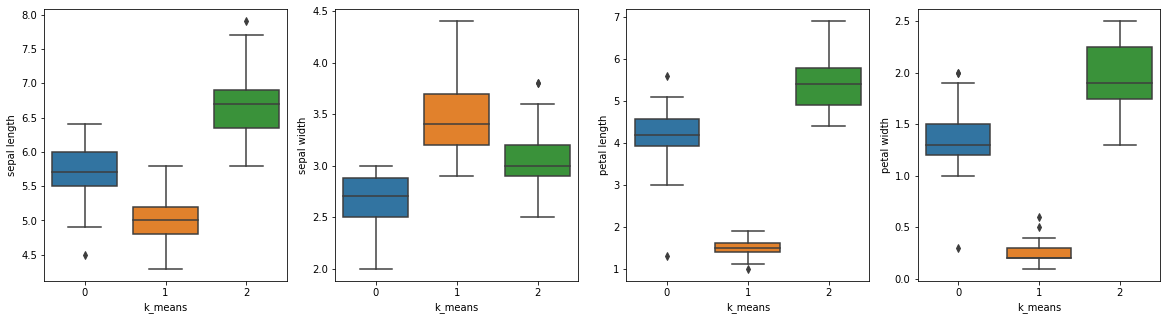

In [17]:
plt.subplots(figsize=(20, 5))
plt.subplot(1,4,1)
sns.boxplot(x='k_means', y='sepal length', data=dataset)
plt.subplot(1,4,2)
sns.boxplot(x='k_means', y='sepal width', data=dataset)
plt.subplot(1,4,3)
sns.boxplot(x='k_means', y='petal length', data=dataset)
plt.subplot(1,4,4)
sns.boxplot(x='k_means', y='petal width', data=dataset)
plt.show()

### Q3. 군집화 및 결과 확인
각 군집이 구분되도록 두 변수의 산포도를 그리는 함수 plot_cluster 구현하시오.

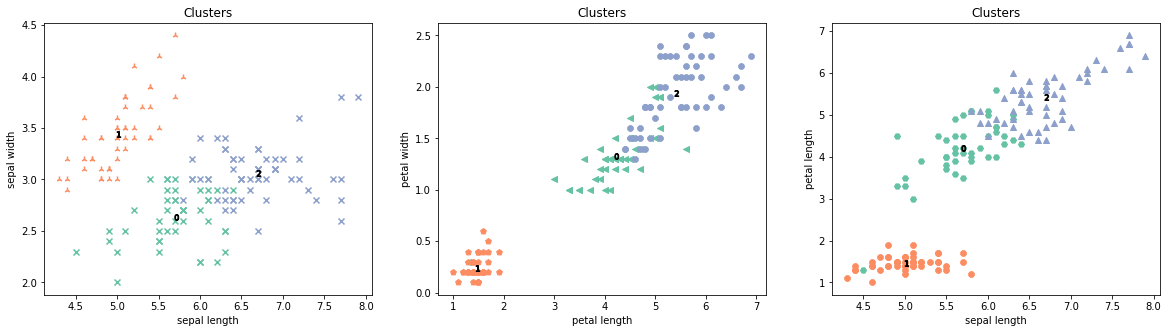

In [18]:
import random
markerstyles = ['o', 'v', '^', '<', '8', '1', '2', 'x', 's', 'p', '*', 'h', 'H', 
                'D', 'd', 'P', 'X']

def plot_cluster(clusters, feat1, feat2):
    rgb_values = sns.color_palette("Set2", len(clusters))
    numbers = [i for i in range(len(clusters))]
    markers = [random.choice(markerstyles) for i in range(len(clusters))]
    new_clusters = [[] for i in range(3)]
    for i in range(len(clusters)):
        each_cluster = clusters[i]
        for j in range(len(each_cluster)):
            tmp = []
            x = each_cluster[j][feat1]
            y = each_cluster[j][feat2]
            tmp.append(x)
            tmp.append(y)
            new_clusters[i].append(tmp)
        
    for i, cluster, marker, color in zip(numbers,
                                        new_clusters,
                                        markers,
                                        rgb_values):
        xs, ys = zip(*cluster)  # magic unzipping trick
        plt.scatter(xs, ys, color=color, marker=marker)

        # put a number at the mean of the cluster
        x, y = vector_mean(cluster)
        plt.plot(x, y, marker='$' + str(i) + '$', color='black')

    plt.title("Clusters")
    plt.xlabel(columns[feat1])
    plt.ylabel(columns[feat2])

clusters = [[] for i in range(3)]
for input, assignment in zip(inputs, assignments):
    clusters[assignment].append(input)

plt.subplots(figsize=(20, 5))
plt.subplot(1,3,1)
plot_cluster(clusters, column2index["sepal length"], column2index["sepal width"])
plt.subplot(1,3,2)
plot_cluster(clusters, column2index["petal length"], column2index["petal width"])
plt.subplot(1,3,3)
plot_cluster(clusters, column2index["sepal length"], column2index["petal length"])
plt.show()

## 5. 계층 군집화 (Hierarchical Clustering)

### Q4. 군집화 및 결과 확인
𝐾=𝟑으로 최장 거리(max) 기준으로 군집화를 해서 다음과 같이 군집화 결과를 확인해 보라.

In [19]:
from typing import NamedTuple, Union, Callable, Tuple
from scratch.linear_algebra import distance

class Leaf(NamedTuple):
    index: int
    value: Vector
        
class Merged(NamedTuple):
    children: tuple
    order: int

Cluster = Union[Leaf, Merged]

def get_assignment(cluster: Cluster) -> List[Vector]:
    if isinstance(cluster, Leaf):
        return [cluster.index]
    else:
        return [index
                for child in cluster.children
                for index in get_assignment(child)]

def get_values(cluster: Cluster) -> List[Vector]:
    if isinstance(cluster, Leaf):
        return [cluster.value]
    else:
        return [value
                for child in cluster.children
                for value in get_values(child)]

def cluster_distance(cluster1: Cluster,
                     cluster2: Cluster,
                     distance_agg: Callable = min) -> float:
    """
    compute all the pairwise distances between cluster1 and cluster2
    and apply the aggregation function _distance_agg_ to the resulting list
    """
    return distance_agg([distance(v1, v2)
                         for v1 in get_values(cluster1)
                         for v2 in get_values(cluster2)])

def get_children(cluster: Cluster):
    if isinstance(cluster, Leaf):
        raise TypeError("Leaf has no children")
    else:
        return cluster.children
    
def get_merge_order(cluster: Cluster) -> float:
    if isinstance(cluster, Leaf):
        return float('inf')  # was never merged
    else:
        return cluster.order
    
def bottom_up_cluster(inputs: List[Vector],
                      distance_agg: Callable = min) -> Cluster:
    # Start with all leaves
    clusters: List[Cluster] = [Leaf(i,input) for i,input in enumerate(inputs)]

    def pair_distance(pair: Tuple[Cluster, Cluster]) -> float:
        return cluster_distance(pair[0], pair[1], distance_agg)

    # as long as we have more than one cluster left...
    while len(clusters) > 1:
        # find the two closest clusters
        c1, c2 = min(((cluster1, cluster2)
                      for i, cluster1 in enumerate(clusters)
                      for cluster2 in clusters[:i]),
                      key=pair_distance)

        # remove them from the list of clusters
        clusters = [c for c in clusters if c != c1 and c != c2]

        # merge them, using merge_order = # of clusters left
        merged_cluster = Merged((c1, c2), order=len(clusters))

        # and add their merge
        clusters.append(merged_cluster)

    # when there's only one cluster left, return it
    return clusters[0]

def generate_clusters(base_cluster: Cluster,
                      num_clusters: int) -> List[Cluster]:
    # start with a list with just the base cluster
    clusters = [base_cluster]

    # as long as we don't have enough clusters yet...
    while len(clusters) < num_clusters:
        # choose the last-merged of our clusters
        next_cluster = min(clusters, key=get_merge_order)
        # remove it from the list
        clusters = [c for c in clusters if c != next_cluster]

        # and add its children to the list (i.e., unmerge it)
        clusters.extend(get_children(next_cluster))

    # once we have enough clusters...
    return clusters

def make_h_assignment(cluster_index, k):
    tmp_assignment = [random.randrange(3) for _ in inputs]
    for i in range(k):
        for j in cluster_index[i]:
            tmp_assignment[j] = i

    return tmp_assignment

base_cluster = bottom_up_cluster(inputs_normed, max)
h_clusters = [get_values(cluster) for cluster in generate_clusters(base_cluster, 3)]
h_clusters_index = [get_assignment(cluster) for cluster in generate_clusters(base_cluster, 3)]
h_assignments = make_h_assignment(h_clusters_index, 3)

#### dataset에 h_clustering 컬럼 추가

In [20]:
dataset["h_clustering"] = h_assignments
dataset.head()

,sepal length,sepal width,petal length,petal width,species,k_means,h_clustering
0,5.1,3.5,1.4,0.2,Iris-setosa,1,1
1,4.9,3.0,1.4,0.2,Iris-setosa,1,1
2,4.7,3.2,1.3,0.2,Iris-setosa,1,1
3,4.6,3.1,1.5,0.2,Iris-setosa,1,1
4,5.0,3.6,1.4,0.2,Iris-setosa,1,1


#### h_clustering과 species 비교

In [21]:
dataset.groupby(["h_clustering", "species"])['h_clustering'].count()

h_clustering  species        
0             Iris-versicolor    29
              Iris-virginica     48
1             Iris-setosa        49
2             Iris-setosa         1
              Iris-versicolor    21
              Iris-virginica      2
Name: h_clustering, dtype: int64

#### 군집화 결과 시각화

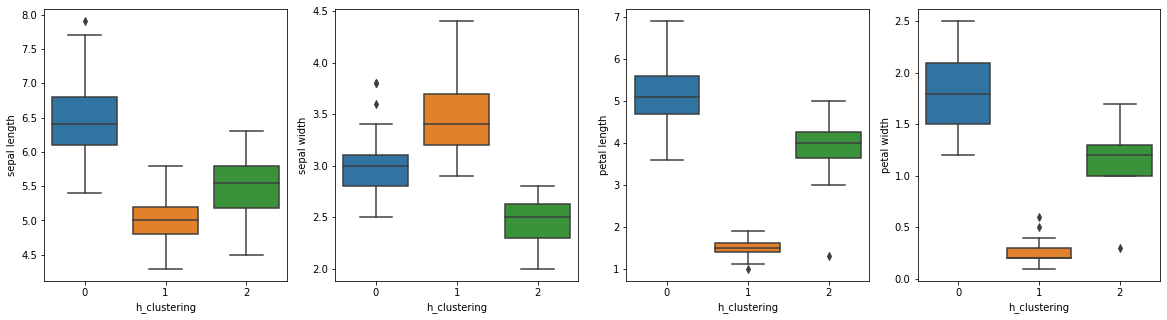

In [22]:
plt.subplots(figsize=(20, 5))
plt.subplot(1,4,1)
sns.boxplot(x = 'h_clustering', y = 'sepal length', data= dataset)
plt.subplot(1,4,2)
sns.boxplot(x = 'h_clustering', y = 'sepal width', data= dataset)
plt.subplot(1,4,3)
sns.boxplot(x = 'h_clustering', y = 'petal length', data= dataset)
plt.subplot(1,4,4)
sns.boxplot(x = 'h_clustering', y = 'petal width', data= dataset)
plt.show()

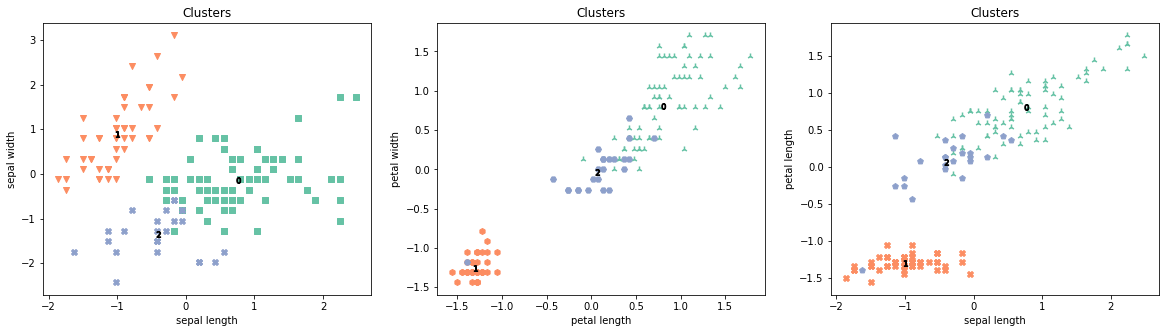

In [23]:
clusters = [[] for i in range(3)]
for input, h_assignment in zip(inputs, h_assignments):
    clusters[h_assignment].append(input)

plt.subplots(figsize=(20, 5))
plt.subplot(1,3,1)
plot_cluster(h_clusters, column2index["sepal length"], column2index["sepal width"])
plt.subplot(1,3,2)
plot_cluster(h_clusters, column2index["petal length"], column2index["petal width"])
plt.subplot(1,3,3)
plot_cluster(h_clusters, column2index["sepal length"], column2index["petal length"])
plt.show()